# TACTIC Files
This notebook contains the code used to generate all figures, tables, and data for the TACTIC manuscript.

## 0. Set Up Environment
Import dependencies and load datasets.

### 0.1 Import dependencies

In [1]:
# Import dependencies
import pickle
from urllib.request import urlopen
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Load data (runtime: ~1 minute)
link = 'https://www.dropbox.com/scl/fi/38ewb000ihqcg6wev41g3/TACTIC_data_master.pkl?rlkey=zvxnt71ejj5ucexgpr1plmyvg&dl=1'
ecoli, mtb, master, out = pickle.load(urlopen(link))

# Instantiate main variable
data = dict()

# Store data
data['TACTIC'] = master['data']
data['importance'] = out['importance']
data['endophthalmitis'] = out['endophthalmitis']

### 0.2 Define GSEA data


#### 0.2.1 E. coli

In [2]:
# Import gene info
df = pd.read_csv('https://rest.kegg.jp/list/eco', sep='\t', header=None)
df.index = [s.split(':')[1] for s in df.iloc[:, 0].tolist()]
df['Gene'] = [s.split(';')[0] for s in df.iloc[:, -1]]
df['Description'] = [s.split('; ')[1] for s in df.iloc[:, -2]]
eco_genes = df[['Gene', 'Description']]

# Import pathway info
df = pd.read_csv('https://rest.kegg.jp/list/pathway/eco', sep='\t', header=None)
df = df.set_index(0).sort_index().rename(columns={1: 'Pathway'})
df['Pathway'] = [p.split(' - ')[0] for p in df['Pathway'].tolist()]
eco_path = df[['Pathway']]

# Import pathways + associated genes
df = pd.read_csv('https://rest.kegg.jp/link/eco/pathway', sep='\t', header=None)
df['pathway'] = [s.split(':')[1] for s in df.iloc[:, 0]]
df['gene'] = [s.split(':')[1] for s in df.iloc[:, 1]]
pathways = sorted(set(df['pathway'].values))
genes = sorted(set(df['gene'].values))
eco = dict()
for path in pathways: 
    eco[path] = df.loc[df['pathway']==path, 'gene'].tolist()
eco_path['N'] = [len(eco[path]) for path in eco_path.index]

# Add pathway to gene info
gene_dict = dict()
for g in genes: 
    pids = df['pathway'].values[df['gene']==g]
    pathway = [eco_path.loc[p, 'Pathway'] for p in pids]
    if len(pathway) > 1: 
        gene_dict[g] = ', '.join(pathway)
    else: 
        gene_dict[g] = pathway[0]
eco_genes['Pathway'] = eco_genes.index.map(gene_dict)

#### 0.2.2 M. tb

In [3]:
# Import gene info
df = pd.read_csv('https://rest.kegg.jp/list/mtu', sep='\t', header=None)
df.index = [s.split(':')[1] for s in df.iloc[:, 0].tolist()]
df['Gene'] = [s.split(';')[0] for s in df.iloc[:, -1]]
def dscr(s): 
    try: 
        return s.split('; ')[1]
    except: 
        return s
df['Description'] = [dscr(s) for s in df.iloc[:, -2]]
mtu_genes = df[['Gene', 'Description']]

# Import pathway info
df = pd.read_csv('https://rest.kegg.jp/list/pathway/mtu', sep='\t', header=None)
df = df.set_index(0).sort_index().rename(columns={1: 'Pathway'})
df['Pathway'] = [p.split(' - ')[0] for p in df['Pathway'].tolist()]
mtu_path = df[['Pathway']]

# Import pathways + associated genes
df = pd.read_csv('https://rest.kegg.jp/link/mtu/pathway', sep='\t', header=None)
df['pathway'] = [s.split(':')[1] for s in df.iloc[:, 0]]
df['gene'] = [s.split(':')[1] for s in df.iloc[:, 1]]
pathways = sorted(set(df['pathway'].values))
genes = sorted(set(df['gene'].values))
mtu = dict()
for path in pathways: 
    mtu[path] = df.loc[df['pathway']==path, 'gene'].tolist()
mtu_path['N'] = [len(mtu[path]) for path in mtu_path.index]

# Add pathway to gene info
gene_dict = dict()
for g in genes: 
    pids = df['pathway'].values[df['gene']==g]
    pathway = [mtu_path.loc[p, 'Pathway'] for p in pids]
    if len(pathway) > 1: 
        gene_dict[g] = ', '.join(pathway)
    else: 
        gene_dict[g] = pathway[0]
mtu_genes['Pathway'] = mtu_genes.index.map(gene_dict)

## 1. Figures

Visualize main and supplementary figures.

### 1.1 Main

#### Figure 1: TACTIC data

In [4]:
# Import relevant functions
import plotly.graph_objects as go

# Define relevant data
ixn_data    = master['data']
source_key  = pd.read_excel('./data/ixn_data.xlsx', sheet_name='source_key', engine='openpyxl')

# Panel A: sources
df = ixn_data.groupby(['Source']).size().reset_index(name='N')
df.loc[df['N'] < 100, 'Source'] = max(df['Source'])+1
df = df.merge(source_key[['Source', 'Reference']], on='Source', how='left')
df.loc[df['Source'] == max(df['Source']), 'Reference'] = 'Other sources'
n = sum(df['Reference'] == 'Other sources') 
df['Reference'] = df['Reference'].replace('Other sources', 'Other sources (N = {})'.format(n))
df = df.groupby(['Reference']).sum()

fig = go.Figure(data=[go.Pie(labels=df.index.tolist(), values=df['N'], hole=0.6)], 
                layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)'))
fig.update_layout(annotations=[dict(text='Sources<br>(N = {})'.format(df.shape[0]+n-1), 
    x=0.5, y=0.51, font_size=24, showarrow=False)], showlegend=False)
fig.update_traces(textposition='outside', textinfo='percent+label', textfont_size=20)
fig.show()

# Panel B: strains
df = ixn_data[['Strain']]
n = len(df['Strain'].unique())
df.loc[df['Strain'].str.contains(r'M. [^t]+', case=True), 'Strain'] = 'Non-TB Mycobacteria'
df = df.groupby(['Strain']).size().reset_index(name='N')
df['Strain'] = df['Strain'].replace('Non-TB Mycobacteria', 'Non-TB Mycobacteria (N = {})'.format(n-df.shape[0]+1))

fig = go.Figure(data=[go.Pie(labels=df['Strain'], values=df['N'], hole=0.6)], 
                layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)'))
fig.update_layout(annotations=[dict(text='Strains<br>(N = {})'.format(n), 
    x=0.5, y=0.51, font_size=24, showarrow=False)], showlegend=False)
fig.update_traces(textposition='outside', textinfo='label+percent', textfont_size=18)
fig.show()

# Panel C: interactions
def f(x): 
    if x['Degree'] > 3: 
        return 'N > 3' 
    else: 
        return 'N = ' + str(x['Degree'])
df = ixn_data[['Metric', 'Label', 'Degree']]
df['Level'] = df.apply(f, axis=1)
df = df.groupby(['Metric', 'Label', 'Level']).size().reset_index(name='N')

x = df.groupby(['Metric']).sum()
y = df.groupby(['Metric', 'Label']).sum()

outer_colors = ['violet', 'slateblue']
inner_colors = ['lightcoral', 'silver', 'lightblue', 'lightcoral', 'silver', 'lightblue']
inner_labels = ['B, A', 'B, N', 'B, S', 'L, A', 'L, N', 'L, S']
inner_donut = go.Pie(
    labels=inner_labels, 
    values=y['N'], 
    hole=0.6,
    sort=False,
    direction='clockwise',
    domain={'x': [0.2, 0.8], 'y': [0.1, 0.9]},
    textinfo='label+percent',
    textposition='inside',
    textfont_size=16, 
    marker={'line': {'color': 'white', 'width': 1}, 'colors': inner_colors}
)
outer_donut = go.Pie(
    labels=x.index.values, 
    values=x['N'], 
    hole=0.8,
    sort=False,
    direction='clockwise',
    domain={'x': [0.1, 0.9], 'y': [0, 1]},
    textinfo='label+percent',
    textposition='outside',
    textfont_size=20, 
    marker={'line': {'color': 'white', 'width': 1}, 'colors': outer_colors}
)
fig = go.Figure(data=[inner_donut, outer_donut], 
                layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)'))
fig.update_layout(annotations=[dict(text='Interactions<br>(N = {})'.format(ixn_data.shape[0]), 
    x=0.5, y=0.5, font_size=20, showarrow=False)], showlegend=False)
fig.show()

C:\Users\carol\AppData\Local\Temp\ipykernel_25968\1413795021.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\carol\AppData\Local\Temp\ipykernel_25968\1413795021.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Figure 2: TACTIC schematic (drawn in MS PowerPoint)

#### Figure 3: TACTIC benchmarking

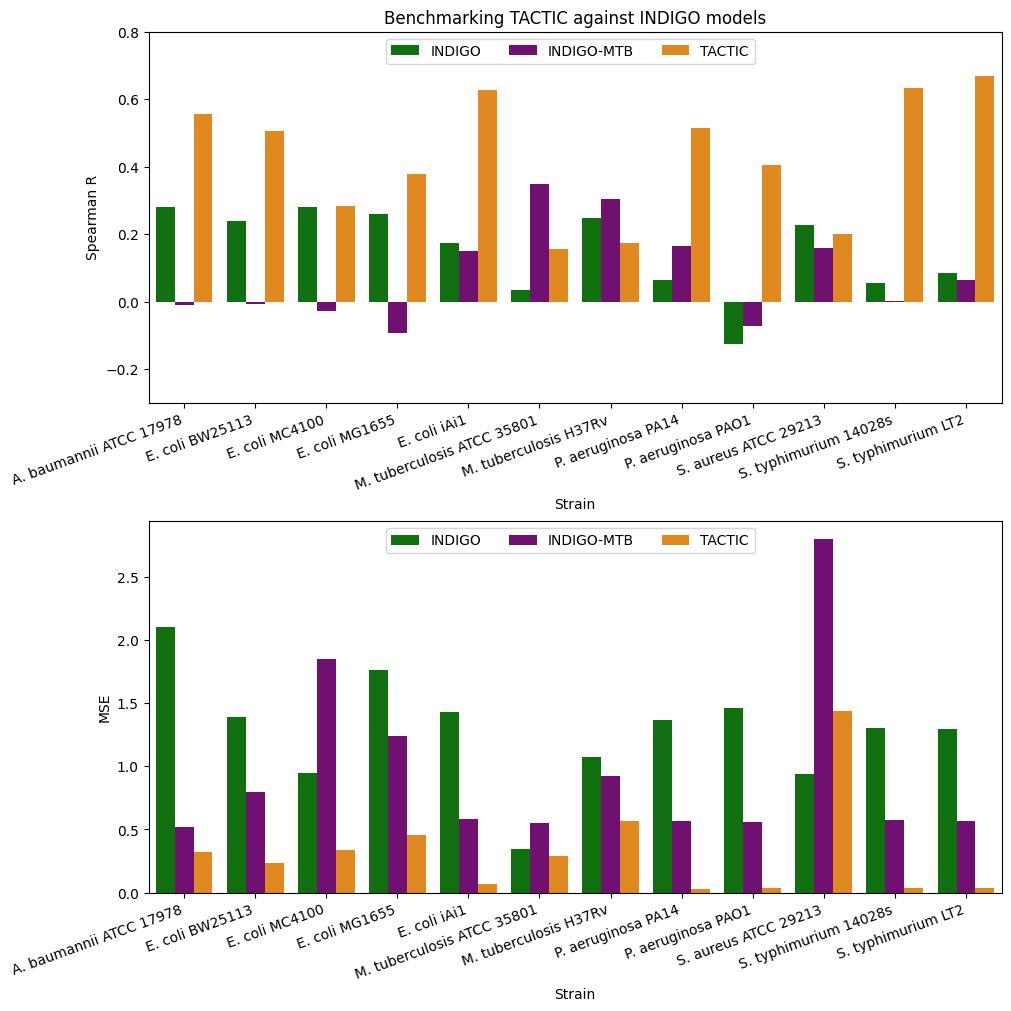

In [5]:
# Import relevant functions
from sklearn.metrics import mean_squared_error as mse

# Format data
strain, ixnN        = [], []
ecoR, mtbR, tacticR = [], [], []
ecoM, mtbM, tacticM = [], [], []
for key, value in out['bench'].items():
    # Skip non-strain entries
    if ' ' not in key: 
        continue
    # Pull relevant data
    else: 
        # Define dataframe
        dfs = value.copy()
        dfs.rename(columns={'EC_holdout': 'EC', 'TB_holdout': 'TB', 'TACTIC_holdout': 'TACTIC'}, inplace=True)
        strain.append(key)
        ixnN.append(dfs.shape[0])
        # Spearman R
        dfr = dfs.iloc[:, 1:].corr(method='spearman')
        rvals = np.round(dfr['Score'][1:].values, 4)
        ecoR.append(rvals[0])
        mtbR.append(rvals[1])
        tacticR.append(rvals[2])
        # MSE
        ecoM.append(mse(dfs['Score'], dfs['EC']))
        mtbM.append(mse(dfs['Score'], dfs['TB']))
        tacticM.append(mse(dfs['Score'], dfs['TACTIC']))
dfBench = pd.DataFrame({'Strain': strain, 'Size': ixnN, 'INDIGO': ecoR, 'INDIGO-MTB': mtbR, 'TACTIC': tacticR})
dfMetric = pd.DataFrame({'Strain': strain, 'Metric': len(strain)*['MSE'], 'INDIGO': ecoM, 'INDIGO-MTB': mtbM, 'TACTIC': tacticM})

# Instantiate figure
fig, axs    = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), constrained_layout=True)

# Panel A: Spearman R
dfPlot = pd.melt(dfBench, id_vars=['Strain'], value_vars=['INDIGO', 'INDIGO-MTB', 'TACTIC'],
        var_name='Model', value_name='Spearman R')
sns.barplot(data=dfPlot, x='Strain', y='Spearman R', hue='Model', palette=['green', 'purple', 'darkorange'], ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=20, horizontalalignment='right')
axs[0].legend(bbox_to_anchor=(0.27, 1), loc='upper left', ncol=3)
axs[0].set_title('Benchmarking TACTIC against INDIGO models')
axs[0].set(ylim=(-0.3, 0.8))

# Panel B: MSE
dfPlot = pd.melt(dfMetric, id_vars=['Strain'], value_vars=['INDIGO', 'INDIGO-MTB', 'TACTIC'],
        var_name='Model', value_name='MSE')
sns.barplot(data=dfPlot, x='Strain', y='MSE', hue='Model', palette=['green', 'purple', 'darkorange'], ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=20, horizontalalignment='right')
axs[1].legend(bbox_to_anchor=(0.27, 1), loc='upper left', ncol=3)

# View figure
plt.show()

#### Figure 4: PCA of TACTIC prediction landscape

Text(0.5, 1.0, 'PCA of strain- and media-specific predictions')

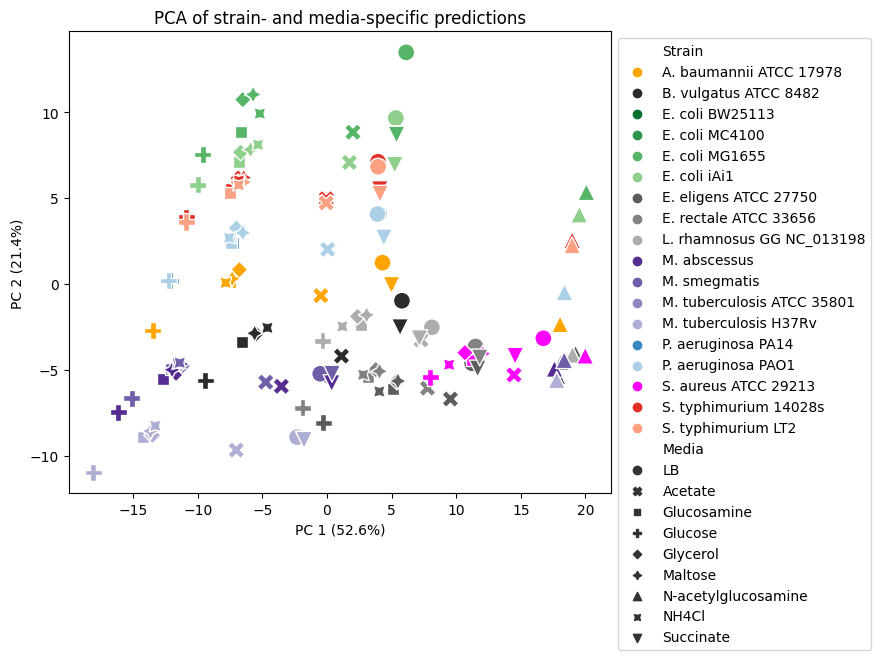

In [6]:
# Import relevant functions
from sklearn.decomposition import PCA
from matplotlib import colors as mcolors

# Define relevant data
df = pd.concat(out['landscape'].values())
df = df.melt(var_name='Strain', value_name='Prediction', ignore_index=False)
ixn_list = [i.rsplit(', ', 1)[0] for i in df.index]
med_list = [i.split(', ')[-1] for i in df.index]
med_list = ['NH4Cl' if m=='NH4CL' else m if m=='LB' else m.capitalize() for m in med_list]
str_list = [s.split()[0][0] + '. ' + s.split(' ', 1)[-1] if '.' not in s else s for s in df['Strain']] 
df1      = pd.DataFrame({'Interaction': ixn_list, 'Media': med_list, 'Strain': str_list, 'Prediction': df.Prediction.values})

# Store data
data['landscape'] = df1

# Re-format data for PCA
df2      = df1.pivot_table(index='Interaction', columns=['Media', 'Strain'])['Prediction']
media    = ['LB', 'Acetate', 'Glucosamine', 'Glucose', 'Glycerol', 'Maltose', 'N-acetylglucosamine', 'NH4Cl', 'Succinate']
strains  = sorted(set(str_list))
df2      = df2.reindex(columns=media, level='Media')

# Conduct PCA
pca = PCA()
components = pca.fit_transform(df2.T)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

# Define plot variables
n = 6
greens = [cs for cs in sns.color_palette('Greens', n)]
purples = [cs for cs in sns.color_palette('Purples', n)]
blues = [cs for cs in sns.color_palette('Blues', 2)]
reds = [cs for cs in sns.color_palette('Reds', 2)]
greys = [cs for cs in sns.color_palette('Greys', n)]
colors = []
c1, c2, c3, c4, c5 = n-1, n-1, 1, 1, n-1
for s in strains: 
    if s.startswith('A. '): 
        colors.append(mcolors.to_rgb('orange'))
    elif s.startswith('S. aureus'): 
        colors.append(mcolors.to_rgb('magenta'))
    elif s.startswith('E. coli'): 
        colors.append(greens[c1])
        c1 -= 1
    elif s.startswith('M. '): 
        colors.append(purples[c2])
        c2 -= 1
    elif s.startswith('P. '): 
        colors.append(blues[c3])
        c3 -= 1
    elif s.startswith('S. typh'): 
        colors.append(reds[c4])
        c4 -= 1
    else: 
        colors.append(greys[c5])
        c5 -= 1

# Define color palette
cmap = dict(zip(strains, colors))
pal = {s: cmap[s] for s in strains}

# Generate PCA plot
pdf = pd.DataFrame(components, columns=list(labels.values()))
pdf['Media'] = [c[0] for c in df2.columns]
pdf['Strain'] = [c[1] for c in df2.columns]
x, y = pdf.columns.values[0], pdf.columns.values[1]
fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(data=pdf, x=x, y=y, palette=pal, hue='Strain', style='Media', s=150, ax=ax)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
ax.set_title('PCA of strain- and media-specific predictions')

#### Figure 5: prediction correlation heatmap

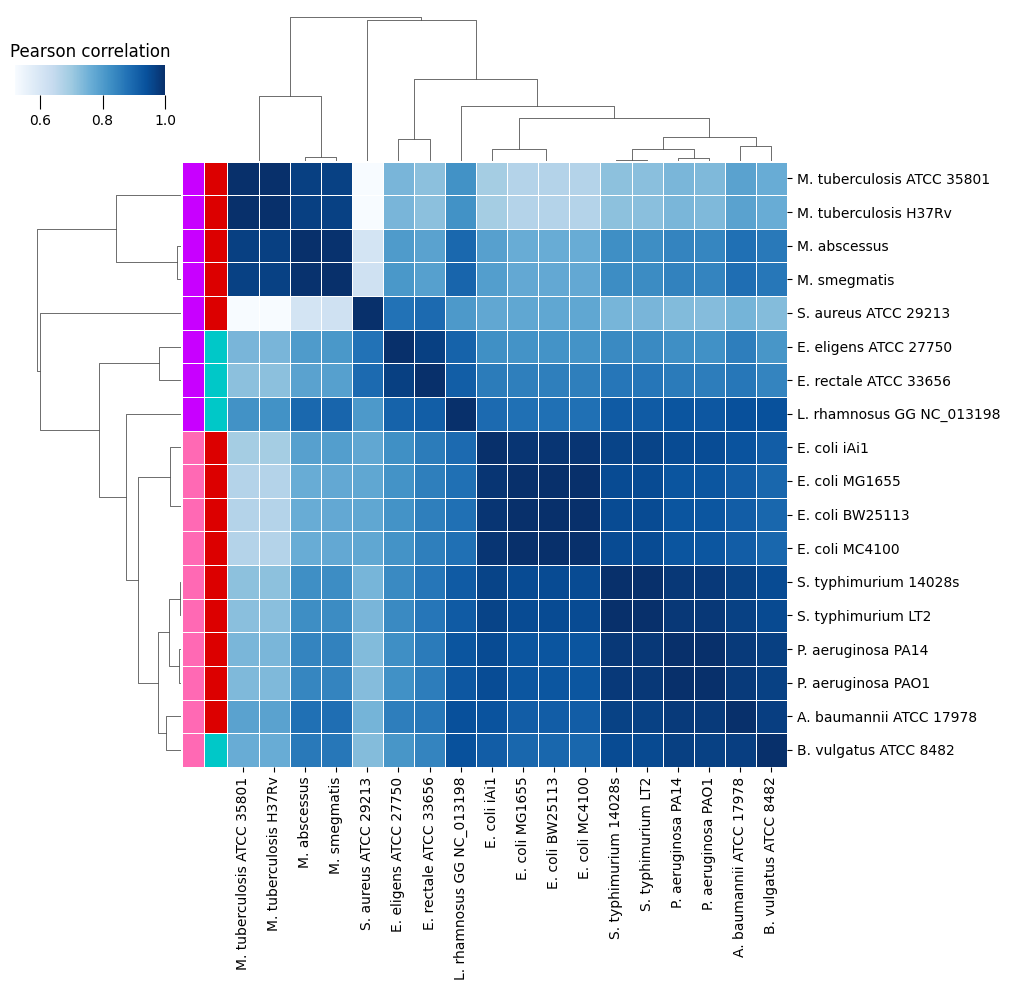

In [7]:
# Define data source + strain groups
df          = out['landscape']['lb'].copy()
strains     = list(df.columns)
pathogens   = [s for s in strains if '.' in s]
commensal   = [s for s in strains if s not in pathogens]
streco      = [s for s in pathogens if s.startswith('E. coli')]
strmtb      = [s for s in pathogens if s.startswith('M. tuber')]
strntm      = [s for s in pathogens if s.startswith(('M. a', 'M. s'))]
strgng      = [s for s in pathogens if s not in strmtb + strntm + ['S. aureus ATCC 29213']]
df.columns  = [s[0] + '. ' + s.split(' ', 1)[-1] if s in commensal else s for s in strains]
commensal   = [s[0] + '. ' + s.split(' ', 1)[-1] for s in commensal]

# Define metadata (Gram stain + strain group)
gstain  = ['Positive' if s.startswith(('M.', 'S. a', 'E. e', 'E. r', 'L.')) else 'Negative' for s in pathogens + commensal]
stype   = len(pathogens) * ['Pathogen'] + len(commensal) * ['Commensal']
gmap    = {'Positive': [200/255, 0, 255/255], 'Negative': [255/255, 105/255, 180/255]}
tmap    = {'Commensal': [0, 200/255, 200/255], 'Pathogen': [220/255, 0, 0]}
grcol   = pd.Series(gstain).map(gmap)
trcol   = pd.Series(stype).map(tmap)

# Generate plot
plot    = df[pathogens + commensal].corr(method='pearson')
kws     = dict(cbar_kws=dict(orientation='horizontal'))
cg      = sns.clustermap(plot, row_colors=[grcol, trcol], linewidths=0.5, cmap='Blues', annot=False, **kws)
x0, _, _, _ = cg.cbar_pos
cg.ax_cbar.set_position([0, 0.9, 0.15, 0.03])
cg.ax_cbar.set_title('Pearson correlation')
cg.ax_cbar.tick_params(axis='x', length=10)

#### Figure 6: narrow-spectrum synergies (pathogens)

Synergy criterium based on mean across group < 0.
Synergy criterium based on all predictions across group < 0.
Syenrgy criterium based on all predictions across group < -0.2.


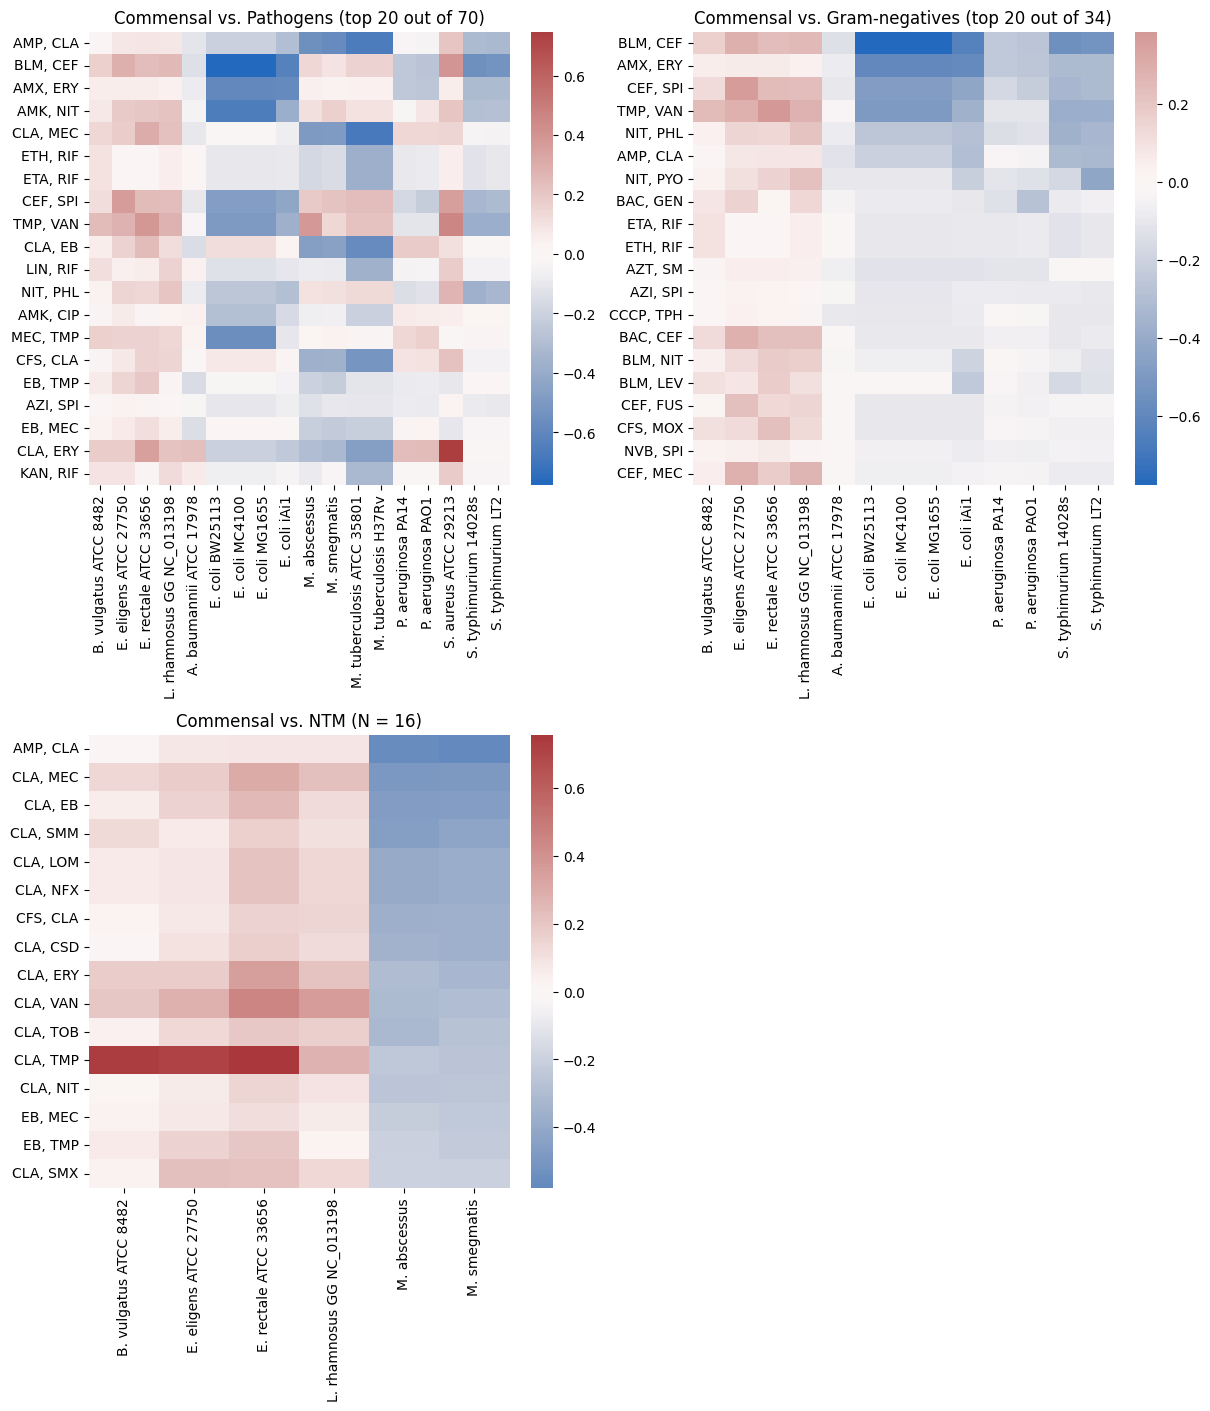

In [8]:
# Define data to visualize
fig, axs    = plt.subplots(nrows=2, ncols=2, figsize=(12, 14), constrained_layout=True)
df          = out['landscape']['lb'].copy()
df.index    = [i.rsplit(', ', 1)[0] for i in df.index]
df.columns  = [s[0] + '. ' + s.split(' ', 1)[-1] if '.' not in s else s for s in df.columns]
n           = 20

# Panel A: commensal vs. pathogens
ax = axs[0, 0]
g1, g2 = 'Commensal', 'Pathogens'
s1, s2 = commensal, pathogens
ix1 = (df[s1] >= 0).all(axis='columns')
ix2 = (df[s2] < -0.2).all(axis='columns') # strong synergies
if sum(ix1 * ix2 == 1) == 0: 
    ix2 = (df[s2] < 0).all(axis='columns') # all synergies
    if sum(ix1 * ix2 == 1) == 0: 
        ix2 = (df[s2].mean(axis=1) < -0.2) # strong mean synergy
        if sum(ix1 * ix2 == 1) < 10: 
            ix2 = (df[s2].mean(axis=1) < 0) # mean synergy
            print('Synergy criterium based on mean across group < 0.')
        else: 
            print('Synergy criterium based on mean across group < -0.2.')
    else: 
        print('Synergy criterium based on all predictions across group < 0.')
else: 
    print('Syenrgy criterium based on all predictions across group < -0.2.')
mask = [all(ix) for ix in zip(ix1, ix2)]
plot = df.loc[mask][s1 + s2]
x = plot[s1].mean(axis=1)
y = plot[s2].mean(axis=1)
idx = np.argsort(x * y)
idx = np.argsort(y)
if len(idx) <= n: 
    sns.heatmap(plot.iloc[idx], annot=False, cmap='vlag', center=0, ax=ax)
    ax.set_title('{} vs. {} (N = {})'.format(g1, g2, len(idx)))
else: 
    sns.heatmap(plot.iloc[idx[:n]], annot=False, cmap='vlag', center=0, ax=ax)
    ax.set_title('{} vs. {} (top {} out of {})'.format(g1, g2, n, len(idx)))

# Panel B: commensal vs. G-
ax = axs[0, 1]
g1, g2 = 'Commensal', 'Gram-negatives'
s1, s2 = commensal, strgng
ix1 = (df[s1] >= 0).all(axis='columns')
ix2 = (df[s2] < -0.2).all(axis='columns') # strong synergies
if sum(ix1 * ix2 == 1) == 0: 
    ix2 = (df[s2] < 0).all(axis='columns') # all synergies
    if sum(ix1 * ix2 == 1) == 0: 
        ix2 = (df[s2].mean(axis=1) < -0.2) # strong mean synergy
        if sum(ix1 * ix2 == 1) == 0: 
            ix2 = (df[s2].mean(axis=1) < 0) # mean synergy
            print('Synergy criterium based on mean across group < 0.')
        else: 
            print('Synergy criterium based on mean across group < -0.2.')
    else: 
        print('Synergy criterium based on all predictions across group < 0.')
else: 
    print('Syenrgy criterium based on all predictions across group < -0.2.')
mask = [all(ix) for ix in zip(ix1, ix2)]
plot = df.loc[mask][s1 + s2]
x = plot[s1].mean(axis=1)
y = plot[s2].mean(axis=1)
idx = np.argsort(x * y)
idx = np.argsort(y)
if len(idx) <= n: 
    sns.heatmap(plot.iloc[idx], annot=False, cmap='vlag', center=0, ax=ax)
    ax.set_title('{} vs. {} (N = {})'.format(g1, g2, len(idx)))
else: 
    sns.heatmap(plot.iloc[idx[:n]], annot=False, cmap='vlag', center=0, ax=ax)
    ax.set_title('{} vs. {} (top {} out of {})'.format(g1, g2, n, len(idx)))

# Panel C: commensal vs. NTM
ax = axs[1, 0]
g1, g2 = 'Commensal', 'NTM'
s1, s2 = commensal, strntm
ix1 = (df[s1] >= 0).all(axis='columns')
ix2 = (df[s2] < -0.2).all(axis='columns') # strong synergies
if sum(ix1 * ix2 == 1) == 0: 
    ix2 = (df[s2] < 0).all(axis='columns') # all synergies
    if sum(ix1 * ix2 == 1) == 0: 
        ix2 = (df[s2].mean(axis=1) < -0.2) # strong mean synergy
        if sum(ix1 * ix2 == 1) == 0: 
            ix2 = (df[s2].mean(axis=1) < 0) # mean synergy
            print('Synergy criterium based on mean across group < 0.')
        else: 
            print('Synergy criterium based on mean across group < -0.2.')
    else: 
        print('Synergy criterium based on all predictions across group < 0.')
else: 
    print('Syenrgy criterium based on all predictions across group < -0.2.')
mask = [all(ix) for ix in zip(ix1, ix2)]
plot = df.loc[mask][s1 + s2]
x = plot[s1].mean(axis=1)
y = plot[s2].mean(axis=1)
idx = np.argsort(x * y)
idx = np.argsort(y)
if len(idx) <= n: 
    sns.heatmap(plot.iloc[idx], annot=False, cmap='vlag', center=0, ax=ax)
    ax.set_title('{} vs. {} (N = {})'.format(g1, g2, len(idx)))
else: 
    sns.heatmap(plot.iloc[idx[:n]], annot=False, cmap='vlag', center=0, ax=ax)
    ax.set_title('{} vs. {} (top {} out of {})'.format(g1, g2, n, len(idx)))

# Blank axis
axs[1, 1].axis('off')

# Display figure
plt.show()

#### Figure 7: experimental validation (M. smegmatis)

C:\Users\carol\AppData\Local\Temp\ipykernel_25968\4181730893.py:73: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\carol\AppData\Local\Temp\ipykernel_25968\4181730893.py:73: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\carol\AppData\Local\Temp\ipykernel_25968\4181730893.py:73: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\carol\AppData\Local\Temp\ipykernel_25968\4181730893.py:73: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\carol\AppData\Local\Temp\ipykernel_25968\4181730893.py:73: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, w

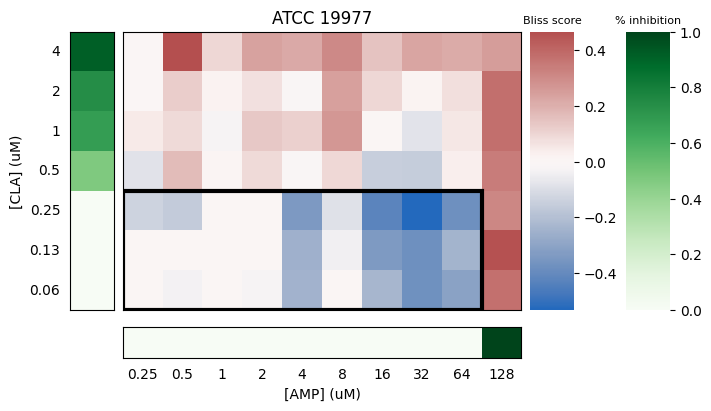

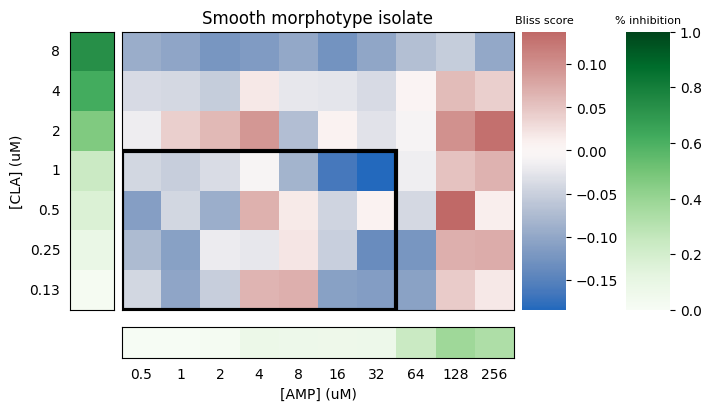

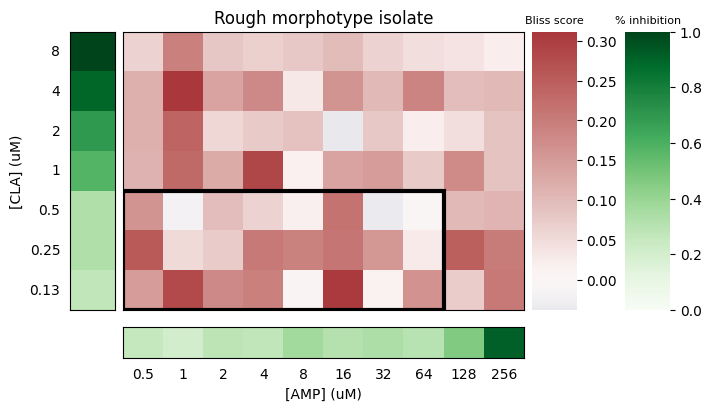

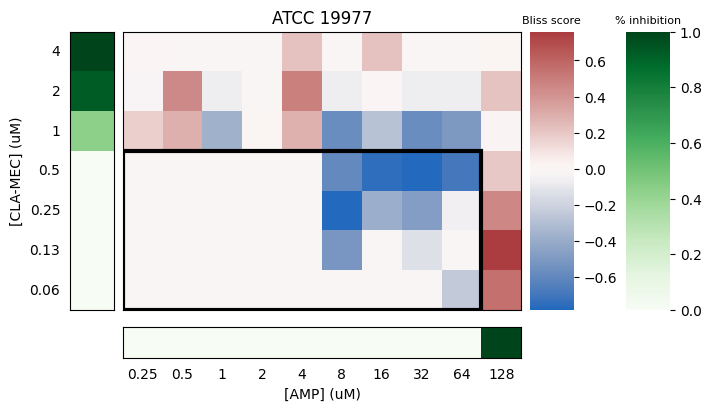

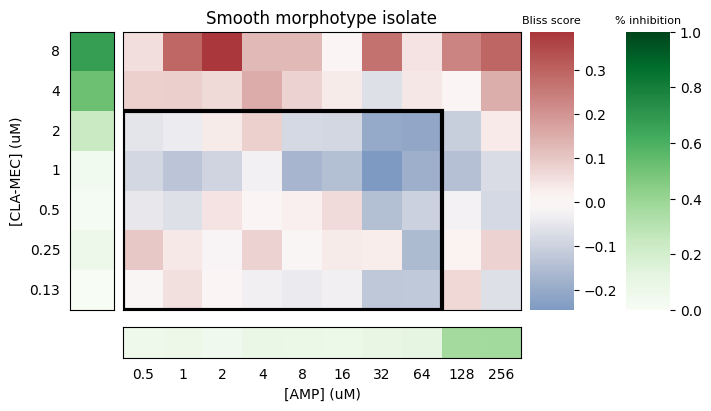

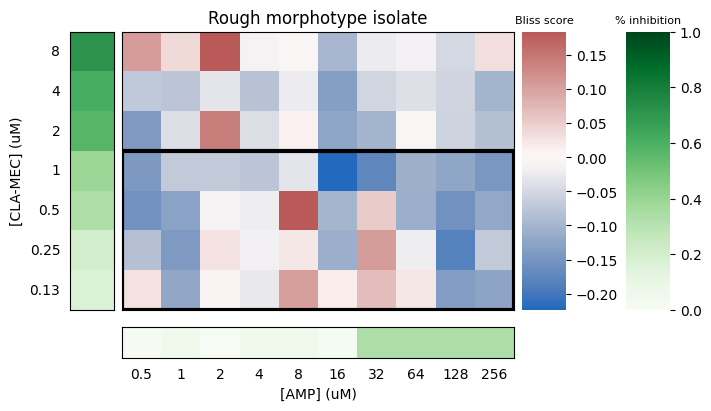

In [9]:
# Import relevant functions
from matplotlib.patches import Rectangle

# Load relevant data
exp = pd.read_excel('./data/Brunaugh_heatmaps.xlsx', sheet_name=None, index_col=0, engine='openpyxl')

# Define custom borders
coord = [(0, 4), (0, 3), (0, 4), (0, 3), (0, 2), (0, 3)]
dist  = [(9, 3), (7, 4), (8, 3), (9, 4), (8, 5), (10, 4)]

# Generate checkerboard heatmaps
counter = 0
for key, value in exp.items(): 
    # Extract information from key and df
    combo, strain = key.split('_')
    xdrug, ydrug = combo.split('-', maxsplit=1)
    if strain=='ATCC': 
        strain = strain + ' 19977'
    elif strain=='S': 
        strain = 'Smooth morphotype isolate'
    elif strain=='R': 
        strain = 'Rough morphotype isolate'
    # Define data
    df = value.copy()
    df = df[df.columns[::-1]]
    nx, ny = df.shape[1]-1, df.shape[0]-1
    xlab = [str(s).split('.')[0] if str(s).endswith('0') else str(s) for s in df.columns[1:]]
    ylab = [str(s).split('.')[0] if str(s).endswith('0') else str(s) for s in df.index[:-1]]
    mscore = round(np.mean(df), 3)
    # Set figure specs
    fig, axs = plt.subplots(2, 4, figsize=(7, 4), constrained_layout=True, 
                            gridspec_kw={'width_ratios': [0.1, 0.9, 0.1, 0.1], 'height_ratios': [0.9, 0.1]})
    # Plot drug 1 inhibition (x-axis)
    sns.heatmap(np.reshape(df.iloc[-1, 1:], (1, nx)), annot=False, fmt='.1f', 
                cmap='Greens', vmin=0, vmax=1, 
                cbar_ax=axs[0, 3], ax=axs[1, 1])
    axs[1, 1].tick_params(left=False, bottom=False)
    axs[1, 1].set(xticklabels=xlab, yticklabels=[])
    for _, spine in axs[1, 1].spines.items():
        spine.set_visible(True)
    axs[0, 3].set_title('% inhibition', fontsize=8)
    axs[1, 1].set_xlabel('[' + xdrug + '] (uM)')
    # Plot drug 2 inhibition (y-axis)
    sns.heatmap(np.reshape(df.iloc[:-1, 0], (ny, 1)), annot=False, fmt='.1f', 
                cmap='Greens', vmin=0, vmax=1, 
                cbar=False, ax=axs[0, 0])
    axs[0, 0].tick_params(left=False, bottom=False)
    axs[0, 0].set(xticklabels=[])
    axs[0, 0].set_yticklabels(labels=ylab, rotation=0)
    for _, spine in axs[0, 0].spines.items():
        spine.set_visible(True)
    axs[0, 0].set_ylabel('[' + ydrug + '] (uM)')
    # Plot bliss score heatmap
    sns.heatmap(df.iloc[:-1, 1:], cmap='vlag', center=0, 
                cbar_ax=axs[0, 2], ax=axs[0, 1])
    axs[0, 1].tick_params(left=False, bottom=False)
    axs[0, 1].set(xticklabels=[], yticklabels=[])
    for _, spine in axs[0, 1].spines.items():
        spine.set_visible(True)
    axs[0, 1].set_title(strain)
    axs[0, 2].set_title('Bliss score', fontsize=8)
    # Add custom border
    x, y = coord[counter]
    l, w = dist[counter]
    border = Rectangle((x, y), l, w, fill=False, edgecolor='black', lw=3)
    axs[0, 1].add_patch(border)
    counter += 1
    # Assign whitespace to unused axes
    axs[1, 0].axis('off')
    axs[1, 2].axis('off')
    axs[1, 3].axis('off')
    # Show figure
    fig.show()

#### Figure 8: narrow-spectrum synergies (endophthalmitis)

Synergy criterium based on all predictions across group < 0.


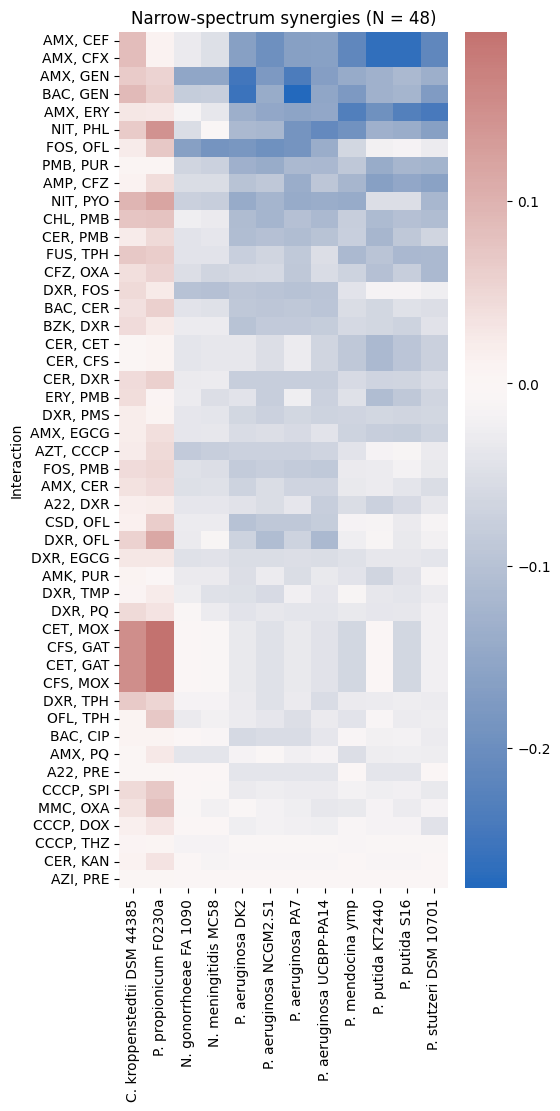

In [10]:
# Define relevant data
df          = out['endophthalmitis'].copy()
commensal   = [s for s in df.columns if s.startswith(('Coryne', 'Pro'))]
pathogens   = [s for s in df.columns if s not in commensal]
df          = df[commensal + pathogens]

# Process data
ix1         = (df[commensal] >= 0).all(axis='columns')
ix2         = (df[pathogens] < -0.2).all(axis='columns') # strong synergies
if sum(ix1 * ix2 == 1) == 0: 
    ix2 = (df[pathogens] < 0).all(axis='columns') # all synergies
    if sum(ix1 * ix2 == 1) == 0: 
        ix2 = (df[pathogens].mean(axis=1) < -0.2) # strong mean synergy
        if sum(ix1 * ix2 == 1) == 0: 
            ix2 = (df[pathogens].mean(axis=1) < 0) # mean synergy
            print('Synergy criterium based on mean across group < 0.')
        else: 
            print('Synergy criterium based on mean across group < -0.2.')
    else: 
        print('Synergy criterium based on all predictions across group < 0.')
else: 
    print('Syenrgy criterium based on all predictions across group < -0.2.')
mask = [all(ix) for ix in zip(ix1, ix2)] 
plot = df.loc[mask]

# Store data
data['endo_set'] = plot

# Generate plot
fig, axs    = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 11), constrained_layout=True)
y, n        = plot[pathogens].mean(axis=1), 20
idx         = np.argsort(y)
plot.columns = [s[0] + '. ' + s.split(' ', 1)[-1] for s in plot.columns]
sns.heatmap(plot.iloc[idx], annot=False, cmap='vlag', center=0, ax=axs)
axs.set_title('Narrow-spectrum synergies (N = {})'.format(len(idx)))

# Display figure
plt.show()

### 1.2 Supplementary

#### Figure S1: replicated TACTIC data

757
Empty DataFrame
Columns: [Interaction, Source, Strain, Metric, Label, N_interaction, N_source, N_strain, N_metric, N_label, Min, Median, Max, SD, N_ixn_strain]
Index: []


C:\Users\carol\AppData\Local\Temp\ipykernel_25968\1008199956.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



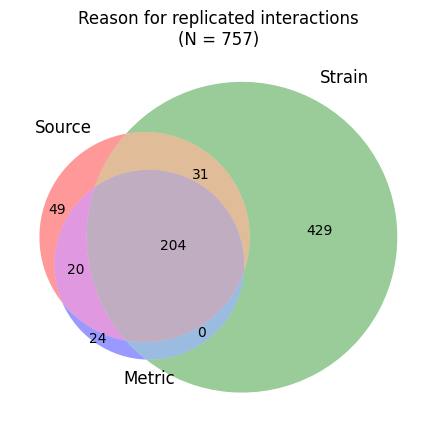

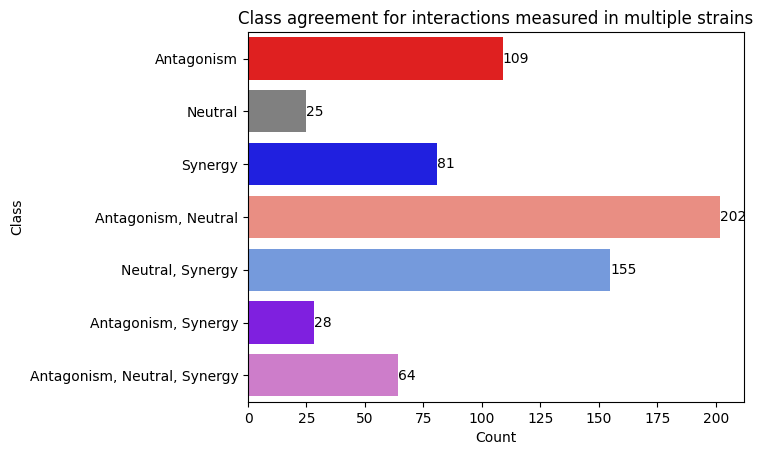

C:\Users\carol\AppData\Local\Temp\ipykernel_25968\1008199956.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\carol\AppData\Local\Temp\ipykernel_25968\1008199956.py:76: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



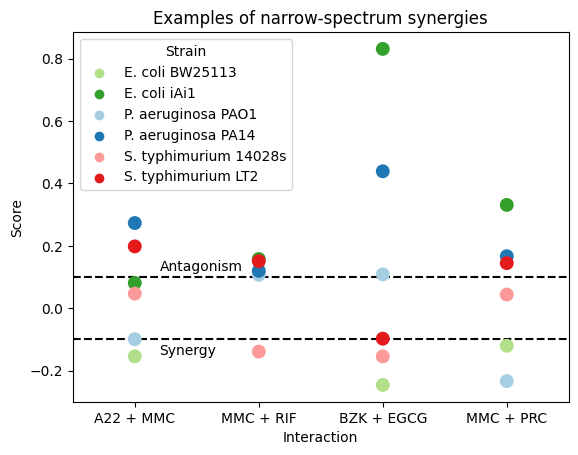

In [11]:
# Import relevant functions
from matplotlib_venn import venn3

# Define relevant data
df = master['data']
ixns = sorted(list(set(df['Interaction'])))
source, strain, metric, label = [], [], [], []
n1, n2, n3, n4, n5 = [], [], [], [], []
mini, med, maxi, sd = [], [], [], []
for ixn in ixns: 
    x = df[df['Interaction']==ixn]
    source.append(', '.join([str(s) for s in set(x['Source'])]))
    strain.append(', '.join(sorted(list(set(x['Strain'])))))
    metric.append(', '.join(sorted(list(set(x['Metric'])))))
    label.append(', '.join(sorted(list(set(x['Label'])))))
    n1.append(x.shape[0])
    # Sources 8 and 11 collected data from literature
    if any(s in (8, 11) for s in x['Source']) and n1[-1] > 1: 
        n2.append(n1[-1])
    else: 
        n2.append(len(set(x['Source'])))
    n3.append(len(set(x['Strain'])))
    n4.append(len(set(x['Metric'])))
    n5.append(len(set(x['Label'])))
    mini.append(x['Score'].min())
    med.append(x['Score'].median())
    maxi.append(x['Score'].max())
    sd.append(x['Score'].std())
dfs = pd.DataFrame({'Interaction': ixns, 'Source': source, 'Strain': strain, 'Metric': metric, 'Label': label, 
                    'N_interaction': n1, 'N_source': n2, 'N_strain': n3, 'N_metric': n4, 'N_label': n5, 
                    'Min': mini, 'Median': med, 'Max': maxi, 'SD': sd})
dfss = dfs[dfs['N_interaction'] > 1]
dfss['N_ixn_strain'] = dfss['N_interaction'] - dfss['N_strain']

# Store data
data['unique'] = dfs
data['replicated'] = dfss

# Panel A: venn diagram
df_source = dfss[dfss['N_source'] > 1]
df_strain = dfss[dfss['N_strain'] > 1]
df_metric = dfss[dfss['N_metric'] > 1]
ixns1 = set(df_source['Interaction'].tolist())
ixns2 = set(df_strain['Interaction'].tolist())
ixns3 = set(df_metric['Interaction'].tolist())
ixns = set(ixns1.union(ixns2).union(ixns3))
print(len(ixns))
ix = [i not in ixns for i in dfss['Interaction'].tolist()]
print(dfss[ix])
plt.figure(linewidth=10, edgecolor=None, facecolor=None)
venn3([ixns1, ixns2, ixns3], set_labels = ('Source', 'Strain', 'Metric'))
plt.title('Reason for replicated interactions\n(N = {})'.format(len(ixns)))
plt.show()

# Panel B: class labels barchart
dfstr = dfss[dfss['N_strain']>1]
colors = {'Antagonism': "#FF0000", 'Neutral': "#808080", 'Synergy': "#0000FF", 
          'Antagonism, Neutral': "#FA8072", 'Neutral, Synergy': "#6495ED", 
          'Antagonism, Synergy': "#7F00FF", 'Antagonism, Neutral, Synergy': "#DA70D6"}
ax = sns.countplot(data=dfstr, y='Label', palette=colors, 
                   order=['Antagonism', 'Neutral', 'Synergy', 
                          'Antagonism, Neutral', 'Neutral, Synergy', 
                          'Antagonism, Synergy', 'Antagonism, Neutral, Synergy'])
ax.bar_label(ax.containers[0])
ax.set_xlabel('Count')
ax.set_ylabel('Class')
ax.set_title('Class agreement for interactions measured in multiple strains')
plt.show()

# Panel C: Brochado interaction examples
ixns = ['A22, MMC', 'MMC, RIF', 'BZK, EGCG', 'MMC, PRC']
ix1 = [i in ixns for i in df['Interaction'].tolist()]
ix2 = [s==1 for s in df['Source'].tolist()]
df = df[[all(ix) for ix in zip(ix1, ix2)]]
df['Class'] = df['Label']
df['Interaction'] = [s.replace(', ', ' + ') for s in df['Interaction'].tolist()]
ixns = [s.replace(', ', ' + ') for s in ixns]
colors = {'Synergy': "#004CFF", 'Neutral': "#979797", 'Antagonism': "#E00000"}
strains = ['P. aeruginosa PAO1', 'P. aeruginosa PA14', 'E. coli BW25113', 'E. coli iAi1', 
           'S. typhimurium 14028s', 'S. typhimurium LT2']
cmap = dict(zip(list(strains), [tuple(c for c in cs) for cs in sns.color_palette("Paired", len(strains))]))
sorder = ['E. coli BW25113', 'E. coli iAi1', 'P. aeruginosa PAO1', 'P. aeruginosa PA14', 
           'S. typhimurium 14028s', 'S. typhimurium LT2']
sns.stripplot(data=df, x='Interaction', y='Score', hue='Strain', order=ixns, 
              size=10, jitter=False, palette=cmap, hue_order=sorder)
plt.axhline(y=0.1, color='black', linestyle='--')
plt.text(x=0.2, y=0.12, s='Antagonism', color='black', ha='left')
plt.axhline(y=-0.1, color='black', linestyle='--')
plt.text(x=0.2, y=-0.15, s='Synergy', color='black', ha='left')
plt.title('Examples of narrow-spectrum synergies')
plt.show()

#### Figure S2: GSEA results

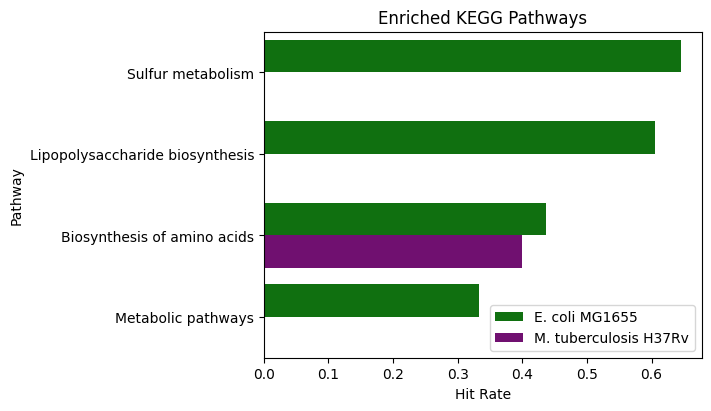

In [12]:
# Instantiate figure
fig, ax = plt.subplots(ncols=1, figsize=(7, 4), constrained_layout=True)

# Process relevant data
df1 = out['gsea']['ecoli'].copy()
df1['Organism'] = 'E. coli MG1655'
df2 = out['gsea']['mtb'].copy()
df2['Organism'] = 'M. tuberculosis H37Rv'
df = pd.concat([df1, df2])
df['Hit Rate'] = round(df['R'] / df['N'], 4)
df = df[df['padj'] < 5E-2]
df = df.sort_values(by=['Hit Rate'], ascending=False)

# Generate plot
cols = ['green' if o.startswith('E. coli') else 'purple' for o in df.Organism]
sns.barplot(data=df, x='Hit Rate', y='Pathway', hue='Organism', dodge=True, palette=['green', 'purple'], ax=ax)
ax.set_title('Enriched KEGG Pathways')
ax.legend(loc='lower right')
plt.show()

#### Figure S3: cross-species feature importance

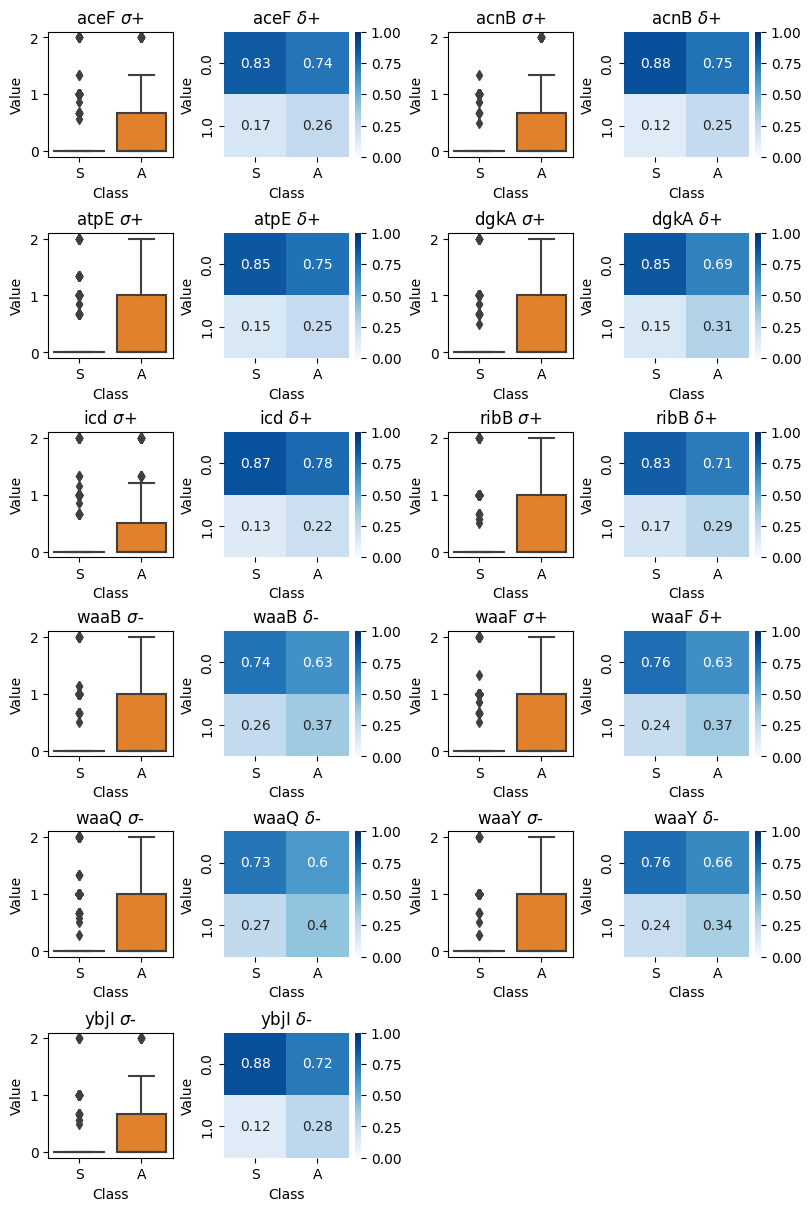

In [13]:
# Define list of features
tags    = ['b0115', 'b0118', 'b0844', 'b1136', 'b3041', 'b3620', 
            'b3625', 'b3628', 'b3632', 'b3737', 'b4042']
gdf     = eco_genes.loc[tags].sort_values(by='Gene')
genes   = np.repeat(gdf['Gene'].values, 2).tolist()
loci    = np.repeat(gdf.index, 2).tolist()
feat    = n * ['sigma', 'delta']
sign    = 12*['pos'] + 2*['neg'] + 2*['pos'] + 6*['neg']
flist   = ['-'.join(z) for z in zip(feat, sign, loci)]
sign    = ['+' if s=='pos' else '-' for s in sign]

# Isolate feature data
sjx     = master['data']['Label'] == 'Synergy'
ajx     = master['data']['Label'] == 'Antagonism'
labels  = master['data']['Label'][sjx | ajx]
labels  = [lab[0] for lab in labels]
fdf     = master['df'].copy()

# Instantiate figure
n = len(flist) // 4 + 1
fig, axs = plt.subplots(nrows=n, ncols=4, figsize=(2*4, 2*n), constrained_layout=True)

# Generate plots
k = 0
for idx, f in enumerate(flist): 
    i, j = k // 4, k % 4
    g, s = genes[idx], sign[idx]
    x = fdf.loc[f].values[sjx | ajx]
    # t-test for sigma values
    if f.startswith('sigma'): 
        vdf = pd.DataFrame({'Class': labels, 'Value': x})
        sns.boxplot(data=vdf, x='Class', y='Value', ax=axs[i, j])
        axs[i, j].set(xlabel='Class', ylabel='Value', title=g + ' ' + r'$\sigma$' + s)
    # chi2 test for delta values
    elif f.startswith('delta'): 
        cdf = pd.crosstab(x, labels)[['S', 'A']]
        sns.heatmap(cdf.div([sum(sjx), sum(ajx)], axis=1), annot=True, 
                    cmap='Blues', vmin=0, vmax=1, ax=axs[i, j])
        axs[i, j].set(xlabel='Class', ylabel='Value', title=g + ' ' + r'$\delta$' + s)
    k += 1

# Blank out unused axes
while k < 4*n: 
    i, j = k // 4, k % 4
    axs[i, j].axis('off')
    k += 1

# Display figure
plt.show()

#### Figure S4: strain-specific drug impact

C:\Users\carol\AppData\Local\Temp\ipykernel_25968\1455314003.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\carol\AppData\Local\Temp\ipykernel_25968\1455314003.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



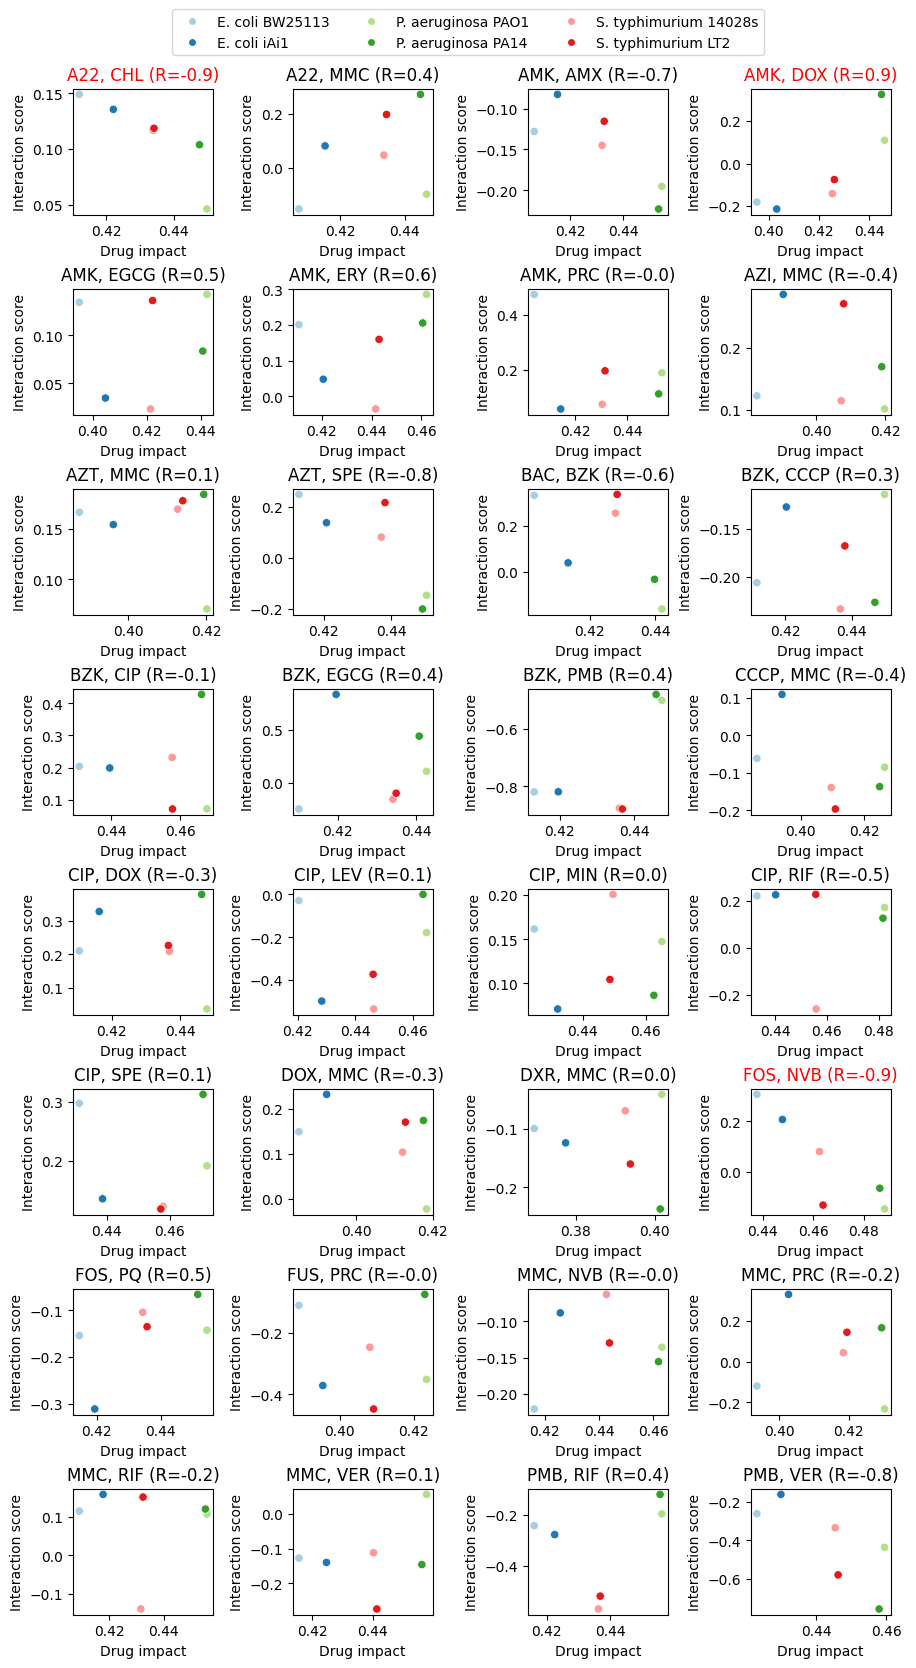

In [14]:
# Import relevant functions
from scipy.stats import spearmanr

# Define relevant data
idx1        = master['data']['Source']==1
dfb         = master['data'][idx1]
ixn_list    = []
for ixn in dfb['Interaction'].unique(): 
    idx = dfb['Interaction']==ixn
    if sum(idx) == 6: 
        ixn_list.append(ixn)
idx2        = [ixn in ixn_list for ixn in master['data']['Interaction']]

# Determine phylogenetic distance
idx3        = [all(s) for s in zip(idx1, idx2)]
df          = master['data'][idx3]
omap        = {key: ecoli['map'][key] + mtb['map'][key] for key in ecoli['map']}
cmap        = {k: len(v) for k, v in omap.items()}
df['N']     = df['Strain'].map(cmap)
X           = master['X'][idx3].toarray()
df['FD']    = np.sqrt(np.sum(np.square(X), axis=1) / df['N'])

# Define color palette
from matplotlib.lines import Line2D
strains     = ['E. coli BW25113', 'E. coli iAi1', 'P. aeruginosa PAO1', 'P. aeruginosa PA14', 
                'S. typhimurium 14028s', 'S. typhimurium LT2']
cmap        = dict(zip(list(strains), [tuple(c for c in cs) for cs in sns.color_palette('Paired', len(strains))]))
cmap        = {k: cmap[k] for k in strains}
handles     = [Line2D([], [], color='white', marker='o', markerfacecolor=v) for k, v in cmap.items()]
labels      = list(cmap.keys())

# Instantiate figure
n = len(ixn_list) // 4 
if len(ixn_list) % 4 > 0: 
    n += 1
fig, axs = plt.subplots(nrows=n, ncols=4, figsize=(2.25*4, 2*n), constrained_layout=True)

# Generate plots
k = 0
for ixn in sorted(ixn_list): 
    i, j = k // 4, k % 4
    ixk = df['Interaction']==ixn
    sns.scatterplot(data=df[ixk], x='FD', y='Score', hue='Strain', palette=cmap, legend=False, ax=axs[i, j])
    axs[i, j].set(xlabel='Drug impact', ylabel='Interaction score')
    r, p = spearmanr(df[ixk]['FD'], df[ixk]['Score'])
    t = '{} (R={:.1f})'.format(ixn, r)
    if p < 0.05:
        axs[i, j].set_title(t, color='red')
    else: 
        axs[i, j].set_title(t)
    k += 1
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.85,1), ncol=len(labels)/2, bbox_transform=fig.transFigure)

#### Figure S5: Biolog box plot

Text(0.5, 1.0, 'Drug interaction outcome across carbon sources (N = 95)')

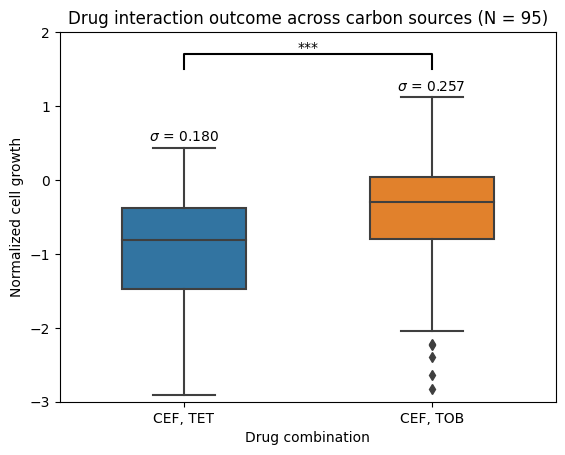

In [15]:
# Import relevant functions
from scipy.stats import ttest_ind

# Load + process biolog data
biolog = pd.read_excel('./data/biolog_pm01.xlsx', sheet_name='data', engine='openpyxl')
df = biolog.pivot_table(index='Media', columns='Drug', sort=False)['AUC']
plot = df.div(df.loc['M9']).apply(np.log2).drop(index='M9')
t, p = ttest_ind(a=plot['CEF, TET'], b=plot['CEF, TOB'], equal_var=False)

# Generate plot
ax = sns.boxplot(plot[['CEF, TET', 'CEF, TOB']], width=0.5)
ax.text(-0.14, 0.53,'$\sigma$ = {:.3f}'.format(df['CEF, TET'].std()), fontsize=10)
ax.text(0.86, 1.2,'$\sigma$ = {:.3f}'.format(df['CEF, TOB'].std()), fontsize=10)
ax.plot([0, 0, 1, 1], [1.5, 1.7, 1.7, 1.5], lw=1.5, c='k')
ax.text(0.5, 1.7, '***', ha='center', va='bottom', color='k')
ax.set(ylim=(-3, 2))
ax.set_xlabel('Drug combination')
ax.set_ylabel('Normalized cell growth')
ax.set_title('Drug interaction outcome across carbon sources (N = {})'.format(plot.shape[0]))

#### Figure S6: TACTIC prediction validation (endophthalmitis)

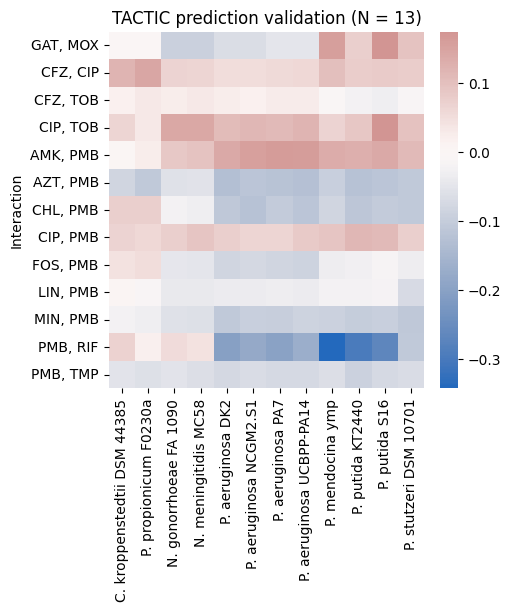

In [16]:
# Define relevant data
df          = out['endophthalmitis'].copy()
commensal   = [s for s in df.columns if s.startswith(('Coryne', 'Pro'))]
pathogens   = [s for s in df.columns if s not in commensal]
ixns1       = ['GAT, MOX', 'CFZ, CIP', 'CFZ, TOB', 'CIP, TOB']
ixns2       = ['AMK, PMB', 'AZT, PMB', 'CHL, PMB', 'CIP, PMB', 
                'FOS, PMB', 'LIN, PMB', 'MIN, PMB', 'PMB, RIF', 'PMB, TMP']
ixns        = ixns1 + ixns2 
plot        = df[commensal + pathogens]
plot.columns = [s[0] + '. ' + s.split(' ', 1)[-1] for s in plot.columns]

# Visualization specs
fig, axs    = plt.subplots(nrows=1, ncols=1, figsize=(5, 6), constrained_layout=True)
sns.heatmap(plot.loc[ixns], annot=False, cmap='vlag', center=0, ax=axs)
axs.set_title('TACTIC prediction validation (N = {})'.format(len(ixns)))

# Show plot
plt.show()

#### Figure S7: Bliss vs. Loewe score agreement

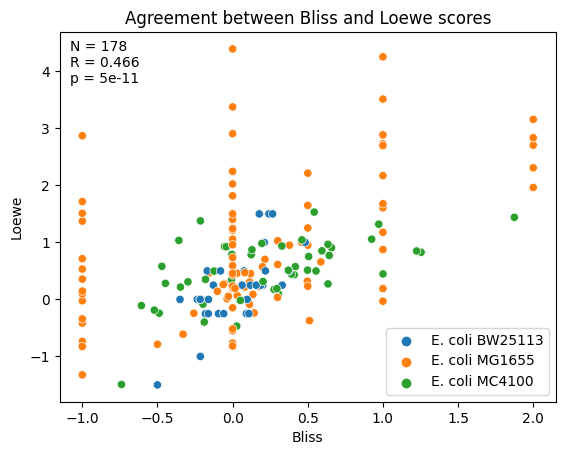

In [17]:
# Define relevant data
df = master['data'].copy()
dfm = dfss[dfss['N_metric']==2]
ixns = dfm['Interaction'].to_list()

# Process data
k = 0
for ixn in ixns: 
    dfi = df[df['Interaction']==ixn]
    for strain in dfi['Strain'].unique(): 
        dfs = dfi[dfi['Strain']==strain]
        if len(dfs['Metric'].unique())==2: 
            dfs = dfs[['Interaction', 'Strain', 'Metric', 'Score']]
            if k==0: 
                dfp = dfs.pivot_table(index=['Interaction', 'Strain'], columns='Metric', sort=False)['Score']
                k =+ 1
            else: 
                dfp = pd.concat([dfp, dfs.pivot_table(index=['Interaction', 'Strain'], columns='Metric', sort=False)['Score']])
dfp['Strain'] = [i[-1] for i in dfp.index]
r, p = spearmanr(dfp['Bliss'], dfp['Loewe'])

# Generate figure
ax = sns.scatterplot(data=dfp, x='Bliss', y='Loewe', hue='Strain')
ax.set_title('Agreement between Bliss and Loewe scores')
ax.text(0.02, 0.98, 'N = {}\nR = {:.3f}\np = {:.0e}'.format(dfp.shape[0], r, p), 
        ha='left', va='top', transform=ax.transAxes)
ax.legend(loc='lower right')

#### Figure S8: ML algorithm comparison

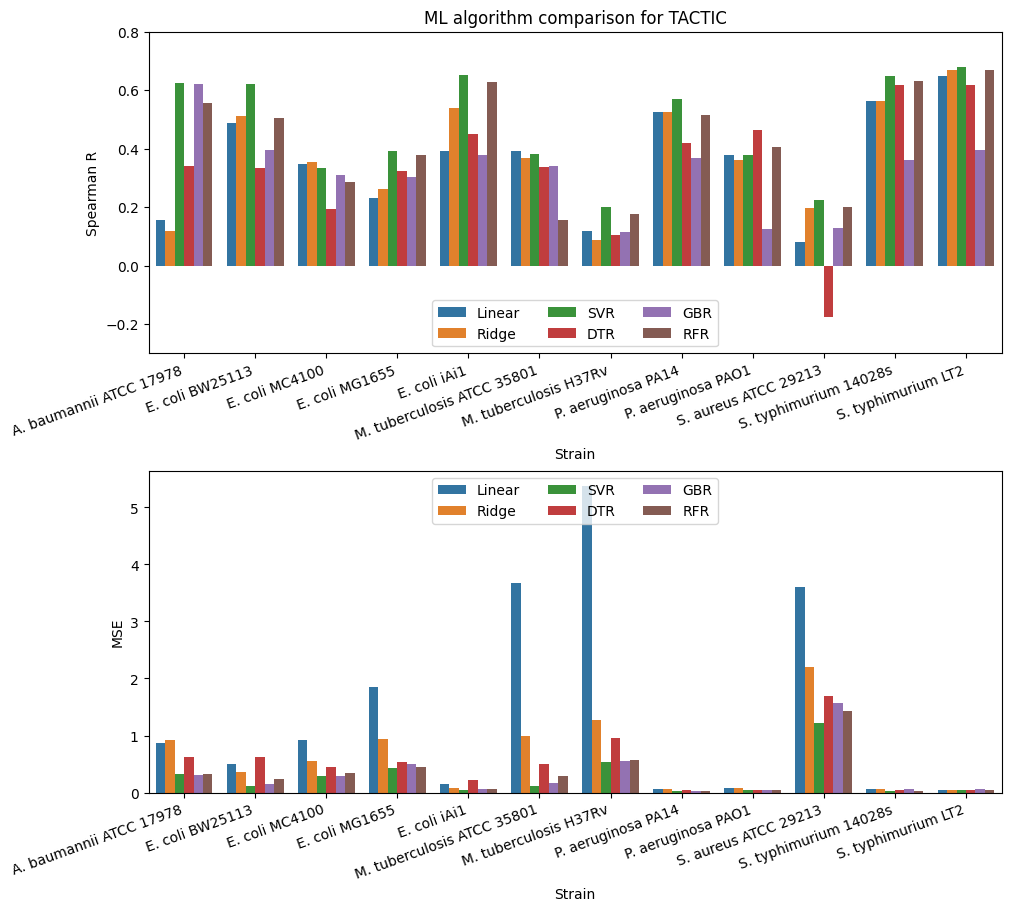

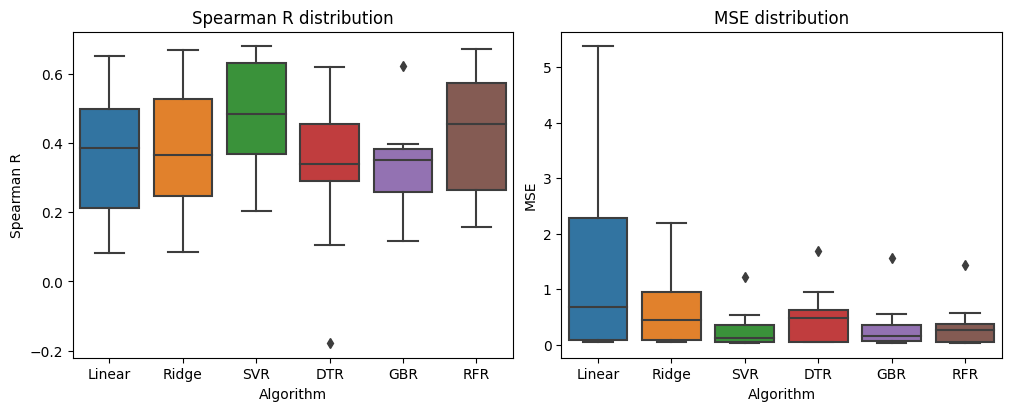

In [18]:
# Extract alternative ML results
strains = [s for s in out['bench'].keys() if ' ' in s]
MLdict  = out['bench']['ML'].copy()
k       = 0
for key, value in MLdict.items(): 
    # Define algorithm name
    if key.startswith('Linear'): 
        alg = 'Linear'
    elif key.startswith('Decision'): 
        alg = 'DTR'
    elif key.startswith('Gradient'): 
        alg = 'GBR'
    else: 
        alg = key
    # Extract data
    rlist, mlist = [], []
    for strain in strains: 
        # Spearman R
        dfr = value[strain].iloc[:, 1:].corr(method='spearman')
        rvals = np.round(dfr['Score'][1:].values, 4)
        rlist.append(rvals[2])
        # MSE
        dfs = value[strain].copy()
        dfs.rename(columns={'TACTIC_holdout': 'TACTIC'}, inplace=True)
        mlist.append(mse(dfs['Score'], dfs['TACTIC']))
    # Define output
    if k==0: 
        plot = pd.DataFrame({'Strain': strains, 'Algorithm': len(strains)*[alg], 'R': rlist, 'M': mlist})
    else: 
        plot = pd.concat([plot, pd.DataFrame({'Strain': strains, 'Algorithm': len(strains)*[alg], 'R': rlist, 'M': mlist})])
    # Update counter
    k += 1

# Add RF results
rlist, mlist = [], []
for strain in strains: 
    # Spearman R
    dfr = out['bench'][strain].iloc[:, 1:].corr(method='spearman')
    rvals = np.round(dfr['Score'][1:].values, 4)
    rlist.append(rvals[2])
    dfs = out['bench'][strain].copy()
    dfs.rename(columns={'TACTIC_holdout': 'TACTIC'}, inplace=True)
    mlist.append(mse(dfs['Score'], dfs['TACTIC']))
plot = pd.concat([plot, pd.DataFrame({'Strain': strains, 'Algorithm': len(strains)*['RFR'], 'R': rlist, 'M': mlist})])
plot.rename(columns={'R': 'Spearman R', 'M': 'MSE'}, inplace=True)

# Instantiate figure
fig, axs    = plt.subplots(nrows=2, ncols=1, figsize=(10, 9), constrained_layout=True)

# Panel A: Spearman R bar chart
sns.barplot(data=plot, x='Strain', y='Spearman R', hue='Algorithm', palette='tab10', ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=20, horizontalalignment='right')
axs[0].legend(loc='lower center', ncol=3)
axs[0].set_title('ML algorithm comparison for TACTIC')
axs[0].set(ylim=(-0.3, 0.8))

# Panel B: MSE bar chart
sns.barplot(data=plot, x='Strain', y='MSE', hue='Algorithm', palette='tab10', clip_on=False, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=20, horizontalalignment='right')
axs[1].legend(loc='upper center', ncol=3)

# Show figure
plt.show()

# Instantiate figure
fig, axs    = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=True)

# Panel C: Spearman R boxplot
dfBench = pd.pivot_table(plot, index='Strain', columns='Algorithm', sort=False)['Spearman R']
sns.boxplot(dfBench, ax=axs[0])
axs[0].set_ylabel('Spearman R')
axs[0].set_title('Spearman R distribution')

# Panel D: MSE boxplot
dfMetric = pd.pivot_table(plot, index='Strain', columns='Algorithm', sort=False)['MSE']
sns.boxplot(dfMetric, ax=axs[1])
axs[1].set_ylabel('MSE')
axs[1].set_title('MSE distribution')

# Show figure
plt.show()

#### Figure S9: adjusted p-value distribution

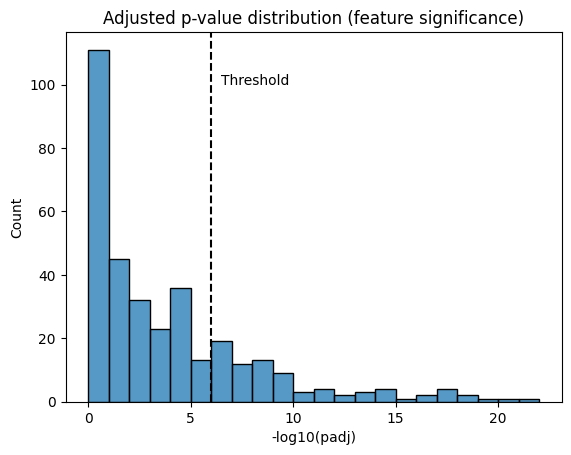

In [19]:
# Define relevant data
df = out['gsea']['features'].copy()
df['-log10(padj)'] = -np.log10(df['padj'].values)

# Generate plot
sns.histplot(data=df, x='-log10(padj)', binwidth=1)
plt.axvline(x=6, color='black', linestyle='--')
plt.text(x=6.5, y=100, s='Threshold', color='black', ha='left')
plt.title('Adjusted p-value distribution (feature significance)')
plt.show()

## 2. Tables

Construct main and supplementary tables.

### 2.1 Main

#### Table 1: TACTIC data collection

In [20]:
# Define relevant data
df = master['data']
strains = sorted(list(set(df['Strain'])))
n, n3, metric, syn, add, ant = [], [], [], [], [], []
for s in strains: 
    x = df[df['Strain']==s]
    n.append(x.shape[0])
    n3.append(sum(x['Degree'] > 2))
    metric.append(', '.join(sorted(list(set(x['Metric'])))))
    syn.append(sum(x['Label'] == 'Synergy'))
    add.append(sum(x['Label'] == 'Neutral'))
    ant.append(sum(x['Label'] == 'Antagonism'))
dfx = pd.DataFrame({'Strain': strains, 'N': n, 'N3': n3, 'Metric': metric, 
                    'Synergy': syn, 'SynP': [round(x1 / x2, 4) for x1, x2 in zip(syn, n)], 
                    'Additive': add, 'AddP': [round(x1 / x2, 4) for x1, x2 in zip(add, n)], 
                    'Antagonism': ant, 'AntP': [round(x1 / x2, 4) for x1, x2 in zip(ant, n)]})

# View table
display(dfx)

,Strain,N,N3,Metric,Synergy,SynP,Additive,AddP,Antagonism,AntP
0,A. baumannii ATCC 17978,45,30,Loewe,23,0.5111,10,0.2222,12,0.2667
1,E. coli BW25113,473,0,"Bliss, Loewe",117,0.2474,155,0.3277,201,0.4249
2,E. coli MC4100,98,26,"Bliss, Loewe",12,0.1224,24,0.2449,62,0.6327
3,E. coli MG1655,623,185,"Bliss, Loewe",123,0.1974,218,0.3499,282,0.4526
4,E. coli iAi1,316,0,Bliss,116,0.3671,66,0.2089,134,0.4241
5,M. tuberculosis ATCC 35801,154,134,Bliss,85,0.5519,41,0.2662,28,0.1818
6,M. tuberculosis H37Rv,389,68,Loewe,181,0.4653,56,0.1440,152,0.3907
7,P. aeruginosa PA14,163,0,Bliss,44,0.2699,47,0.2883,72,0.4417
8,P. aeruginosa PAO1,163,0,Bliss,51,0.3129,54,0.3313,58,0.3558
9,S. aureus ATCC 29213,45,0,Loewe,5,0.1111,23,0.5111,17,0.3778


#### Table 2: feature important genes

In [21]:
# Define relevant data
tags = ['b0115', 'b0118', 'b0844', 'b1136', 'b3041', 'b3620', 
        'b3625', 'b3628', 'b3632', 'b3737', 'b4042']
efdf = eco_genes[[g in tags for g in eco_genes.index]]
efdf = efdf.sort_values(by=['Pathway'])

# View table
display(efdf)

,Gene,Description,Pathway
b1136,icd,isocitrate dehydrogenase,"Citrate cycle (TCA cycle), Glutathione metabol..."
b0118,acnB,hypothetical protein,"Citrate cycle (TCA cycle), Glyoxylate and dica..."
b4042,dgkA,diacylglycerol kinase,"Glycerolipid metabolism, Glycerophospholipid m..."
b0115,aceF,"pyruvate dehydrogenase, E2 subunit","Glycolysis / Gluconeogenesis, Citrate cycle (T..."
b3620,waaF,ADP-heptose--LPS heptosyltransferase 2,"Lipopolysaccharide biosynthesis, Metabolic pat..."
b3625,waaY,lipopolysaccharide core heptose (II) kinase,"Lipopolysaccharide biosynthesis, Metabolic pat..."
b3628,waaB,UDP-D-galactose:(glucosyl)lipopolysaccharide-1...,"Lipopolysaccharide biosynthesis, Metabolic pat..."
b3632,waaQ,lipopolysaccharide core heptosyltransferase 3,"Lipopolysaccharide biosynthesis, Metabolic pat..."
b3737,atpE,ATP synthase Fo complex subunit c,"Oxidative phosphorylation, Metabolic pathways"
b0844,ybjI,5-amino-6-(5-phospho-D-ribitylamino)uracil pho...,"Riboflavin metabolism, Metabolic pathways, Bio..."


#### Table 3: literature-based evidence (manually curated in MS Word)

### 2.2 Supplementary

#### Table S1: endophthalmitis antibiotics (manually curated in MS Word)

#### Table S2: endophthalmitis strains (manually curated in MS Word)

#### Table S3: PCA strain-to-strain cumulative distance

In [22]:
# Import relevant functions
from sklearn.metrics.pairwise import pairwise_distances

# Define relevant data
n = out['landscape']['lb'].shape[1]
cd = []
for k, m in enumerate(media): 
    j1, j2 = k*n, (k+1)*n
    x = components[:, j1:j2]
    d = pairwise_distances(x, metric='euclidean')
    cd.append(np.sum(d)/2)
cdf = pd.DataFrame({'Media': media, 'CD': cd})
cdf.sort_values(by='CD', ascending=False, inplace=True)

# View table
display(cdf)

,Media,CD
0,LB,2.327713e+05
1,Acetate,2.297634e+04
2,Glucosamine,1.155475e+04
3,Glucose,7.330056e+03
4,Glycerol,5.015229e+03
5,Maltose,3.465581e+03
6,N-acetylglucosamine,1.910745e+03
7,NH4Cl,2.403122e+02
8,Succinate,3.214825e-11


## 3. Data

Format and save supplementary data.

### Data S1: TACTIC data

In [23]:
# Export to Excel
with pd.ExcelWriter('./data/TACTIC_output.xlsx', mode='a', if_sheet_exists='replace') as file:
	data['TACTIC'].to_excel(file, sheet_name='Data S1', index=False, engine='openpyxl', freeze_panes=(1, 1))

### Data S2: TACTIC drugs (manually curated in MS Excel)

### Data S3: unique drug interactions

In [24]:
# Export to Excel
with pd.ExcelWriter('./data/TACTIC_output.xlsx', mode='a', if_sheet_exists='replace') as file:
	data['unique'].to_excel(file, sheet_name='Data S3', index=False, engine='openpyxl', freeze_panes=(1, 1))

### Data S4: prediction landscape

In [25]:
# Add 3-way prediction
df = out['AMP-CLA-MEC'].copy()
df.columns  = [s[0] + '. ' + s.split(' ', 1)[-1] if '.' not in s else s for s in df.columns]
df = df.melt(var_name='Strain', value_name='Prediction', ignore_index=False)
df['Interaction'] = df.index.values
df['Media'] = df.shape[0]*['LB']
df = df[data['landscape'].columns]
dfp = pd.concat([data['landscape'].copy(), df])

# Export to Excel (runtime: ~1 minute)
with pd.ExcelWriter('./data/TACTIC_output.xlsx', mode='a', if_sheet_exists='replace') as file:
	dfp.to_excel(file, sheet_name='Data S4', index=False, engine='openpyxl', freeze_panes=(1, 1))

### Data S5: endophthalmitis prediction landscape

In [26]:
# Export to Excel (runtime: ~2 minutes)
with pd.ExcelWriter('./data/TACTIC_output.xlsx', mode='a', if_sheet_exists='replace') as file:
	data['endophthalmitis'].to_excel(file, sheet_name='Data S5', index=True, engine='openpyxl', freeze_panes=(1, 1))

### Data S6: endophthalmitis narrow-spectrum predictions

In [27]:
# Export to Excel (runtime: ~2 minutes)
with pd.ExcelWriter('./data/TACTIC_output.xlsx', mode='a', if_sheet_exists='replace') as file:
	data['endo_set'].to_excel(file, sheet_name='Data S6', index=True, engine='openpyxl', freeze_panes=(1, 1))

### Data S7: TACTIC feature importance

In [28]:
# Export to Excel (runtime: ~2 minutes)
with pd.ExcelWriter('./data/TACTIC_output.xlsx', mode='a', if_sheet_exists='replace') as file:
	data['importance'].to_excel(file, sheet_name='Data S7', index=True, engine='openpyxl', freeze_panes=(1, 1))

### Data S8: GSEA feature significance

In [29]:
# Export to Excel (runtime: ~2 minutes)
with pd.ExcelWriter('./data/TACTIC_output.xlsx', mode='a', if_sheet_exists='replace') as file:
	out['gsea']['features'].to_excel(file, sheet_name='Data S8', index=True, engine='openpyxl', freeze_panes=(1, 1))